# Baysian Staggered DiD

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

island_names  years  island_ids region_codes region_names  \
0           鹿久居島   1975          68        33342          日生町   
1           鹿久居島   1980          68        33342          日生町   
2           鹿久居島   1985          68        33342          日生町   
3           鹿久居島   1990          68        33342          日生町   
4           鹿久居島   1995          68        33342          日生町   
..           ...    ...         ...          ...          ...   
583           戸島   2000         218        38203         宇和島市   
584           戸島   2005         218        38203         宇和島市   
585           戸島   2010         218        38203         宇和島市   
586           戸島   2015         218        38203         宇和島市   
587           戸島   2020         218        38203         宇和島市   

     prefecture_codes  populations  treatment_group  treatment_group_mainland  \
0                  33           46                1                         1   
1                  33           52                1                         1   
2                  33           53                1                         1   
3                  33           54                1                         1   
4                  33           45                1                         1   
..                ...          ...              ...                       ...   
583                38          451                0                         0   
584                38          473                0                         0   
585                38          414                0                         0   
586                38          344                0                         0   
587                38          263                0                         0   

     year_bridges_opened  ...  cohort_2000  years_cohort_2000  cohort_2004  \
0                   2015  ...            0                  0            0   
1                   2015  ...            0                  0            0   
2                   2015  ...            0                  0            0   
3                   2015  ...            0                  0            0   
4                   2015  ...            0                  0            0   
..                   ...  ...          ...                ...          ...   
583                    0  ...            0                  0            0   
584                    0  ...            0                  0            0   
585                    0  ...            0                  0            0   
586                    0  ...            0                  0            0   
587                    0  ...            0                  0            0   

     years_cohort_2004 cohort_2011  years_cohort_2011  cohort_2015  \
0                    0           0                  0            1   
1                    0           0                  0            1   
2                    0           0                  0            1   
3                    0           0                  0            1   
4                    0           0                  0            1   
..                 ...         ...                ...          ...   
583                  0           0                  0            0   
584                  0           0                  0            0   
585                  0           0                  0            0   
586                  0           0                  0            0   
587                  0           0                  0            0   

     years_cohort_2015  cohort_2016  years_cohort_2016  
0                  -40            0                  0  
1                  -35            0                  0  
2                  -30            0                  0  
3                  -25            0                  0  
4                  -20            0                  0  
..                 ...          ...                ...  
583                  0            0                  0  
584             

## TWFE

$$
\mu_{it} = \text{island}_i + \text{year}_t + \sum_{g \in G} \mu_g \mathbf{1} \{t-E_i \in g\} + \epsilon_{it}
$$

- $\text{island}_i$:
  - 個体効果
- $\text{year}_t$:
  - 年効果
- $E_i$:
  - 処置開始年

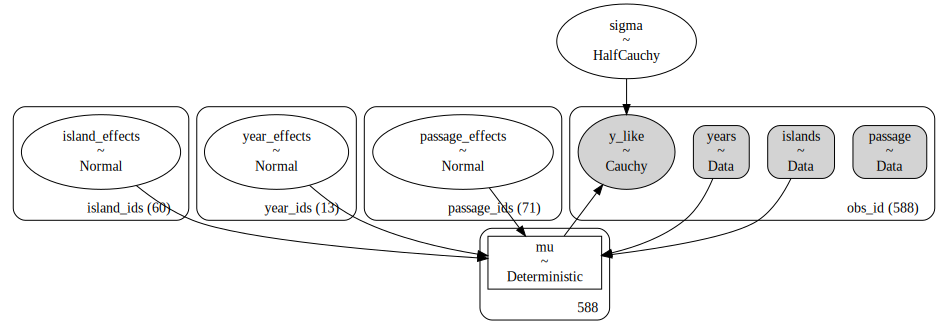

In [5]:
# 経過期間ダミーを作成
passages = dmatrix('C(passage_of_year)', data=df, return_type='dataframe')

# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'passage_ids': df['passage_of_year'].unique(),
    'obs_id': df.index
}

with pm.Model(coords=coords) as twfe:
    # data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    passage = pm.Data('passage', df['passage_of_year'], dims='obs_id')

    # priors
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')
    passage_effects = pm.Normal('passage_effects', mu=0, sigma=100, dims='passage_ids')

    # model error
    sigma = pm.HalfCauchy('sigma', beta=1000000)

    # expectation
    mu = pm.Deterministic('mu', island_effects[islands] + year_effects[years] + pm.math.dot(passages, passage_effects))

    # likelihood
    y_like = pm.Cauchy('y_like', alpha=mu, beta=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(twfe)

In [4]:
with twfe:
    idata_twfe = pm.sample(draws=3000, tune=2000, nuts_sampler='numpyro', random_seed=123)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [6]:
az.to_netcdf(idata_twfe, './sample/sample_baysian_did_twfe.nc')

'./sample/sample_baysian_did_twfe.nc'

In [7]:
az.summary(idata_twfe)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
island_effects[68]   2.529  14.954 -24.832   31.835      0.490    0.347   
island_effects[69]   1.393  14.354 -24.974   28.804      0.488    0.345   
island_effects[70]  -0.527  26.143 -50.714   47.739      0.607    0.429   
island_effects[71]   9.557  16.182 -20.712   40.074      0.517    0.366   
island_effects[76]  -5.685  14.341 -31.555   22.065      0.488    0.345   
...                    ...     ...     ...      ...        ...      ...   
mu[583]            -12.766   1.978 -16.581   -9.070      0.018    0.013   
mu[584]             -5.136   2.442  -9.585   -0.511      0.023    0.016   
mu[585]            -13.396   1.937 -17.129   -9.806      0.018    0.013   
mu[586]            -13.299   2.083 -17.299   -9.584      0.019    0.014   
mu[587]            -18.616   2.248 -22.745  -14.348      0.021    0.015   

                    ess_bulk  ess_tail  r_hat  
island_effects[68]     931.0    2062.0    1.0  
island_effects[69]     863.0    1898.0    1.0  
island_effects[70]    1855.0    3474.0    1.0  
island_effects[71]     978.0    2177.0    1.0  
island_effects[76]     863.0    1960.0    1.0  
...                      ...       ...    ...  
mu[583]              11913.0    9473.0    1.0  
mu[584]              10968.0    9660.0    1.0  
mu[585]              11564.0   10101.0    1.0  
mu[586]              11563.0   10165.0    1.0  
mu[587]              11030.0   10071.0    1.0  

[733 rows x 9 columns]

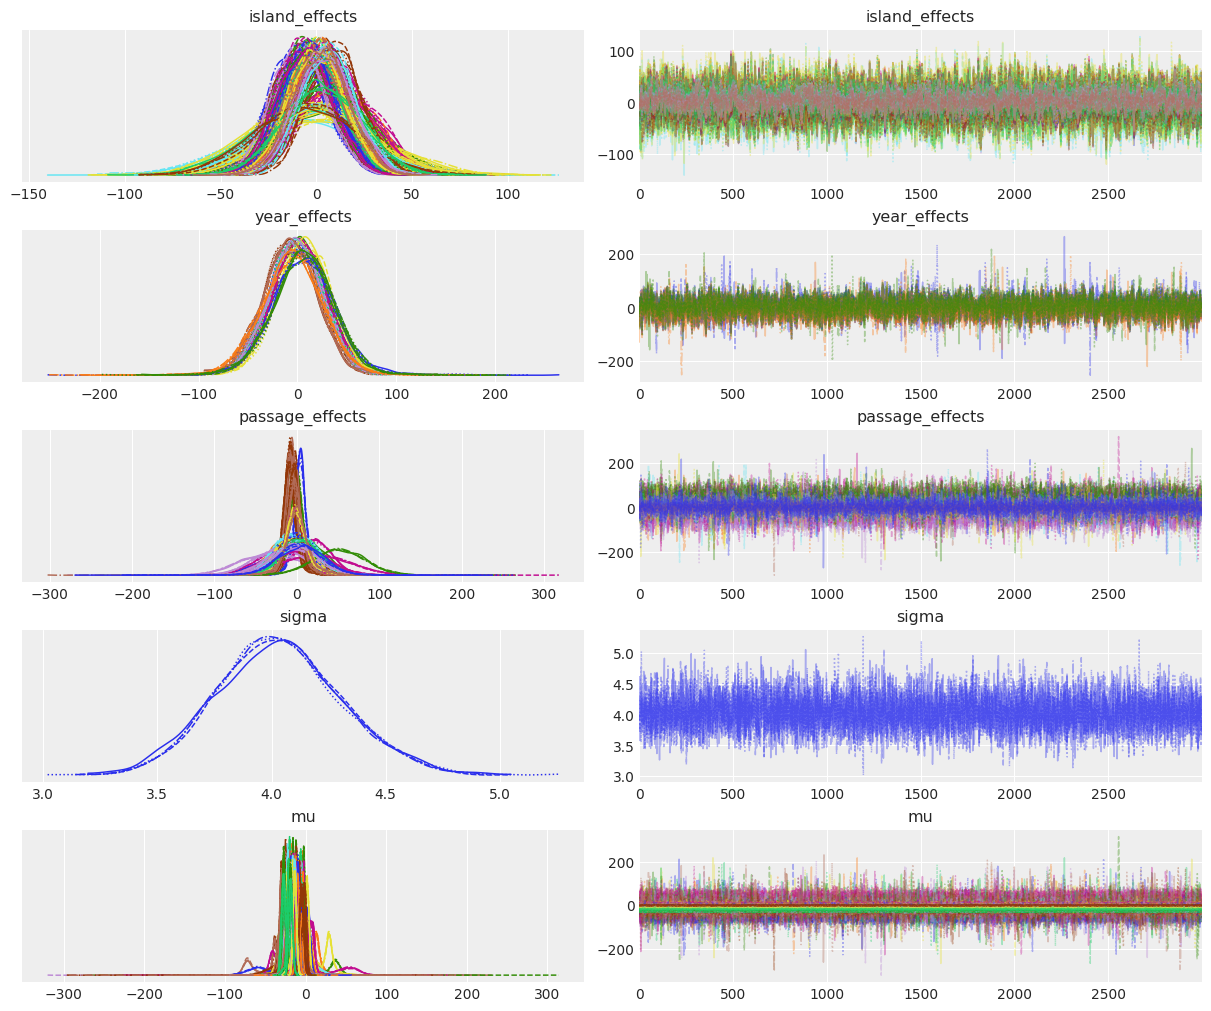

In [8]:
az.plot_trace(idata_twfe);

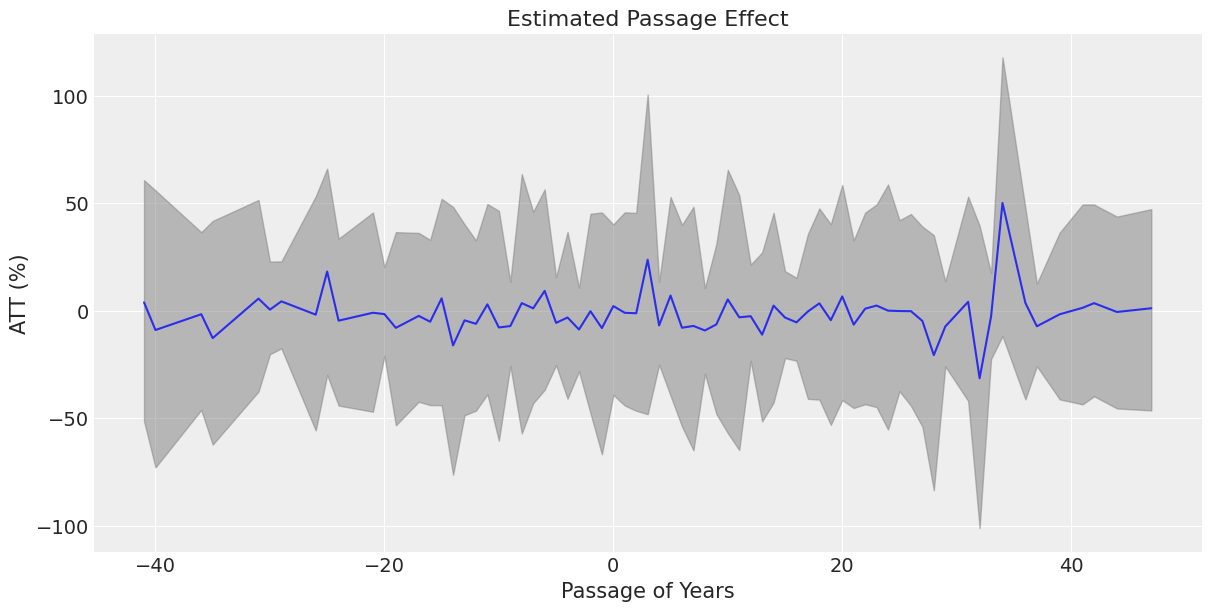

In [9]:
summary = az.summary(idata_twfe, var_names=['passage_effects'], hdi_prob=.95)
df_passage_effects = summary.reset_index()
# 数値部分を取り出す関数
def extract_number(index_str):
    match = re.search(r'\[(.*?)\]', index_str)
    return int(match.group(1)) if match else None

# 数値部分を新しい列として追加
df_passage_effects['passage_years'] = df_passage_effects['index'].apply(extract_number)
df_passage_effects.sort_values('passage_years', inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x='passage_years', y='mean', data=df_passage_effects)
plt.fill_between(
    df_passage_effects['passage_years'],
    df_passage_effects['hdi_2.5%'],
    df_passage_effects['hdi_97.5%'],
    color='gray', alpha=0.5, label='95% HDI'
)
plt.title('Estimated Passage Effect')
plt.xlabel('Passage of Years')
plt.ylabel('ATT (%)')
plt.show()

### Staggered DiD

$$
\mu_{it} = \text{island}_i + \text{year}_t + \sum_{g \in G} \mu_{gl} \mathbf{1} \{\text{year}-\text{intervention}_i \in g\} \cdot \mathbf{1} \{\text{intervention}_i \in e\} + \epsilon_{it}
$$

- $\text{island}_i$:
  - 島効果
- $\text{year}_t$:
  - 年効果
- $E_i$:
  - 処置開始年
- $\mathbf{1} \{t-E_i \in g\}$:
  - 経過年数ダミー
- $\mathbf{1} \{E_i \in e\}$
  - 処置開始年ダミー


In [12]:
cohort_list = df['year_bridges_opened'].unique()

for cohort in cohort_list:
    globals()[f'c{cohort}'] = dmatrix(f'C(years_cohort_{cohort})-1', data=df, return_type='dataframe')
    print(cohort)

2015
0
2004
1989
1983
1991
1987
1992
1979
2000
1973
1976
1988
1996
2011
1995
1999
2016


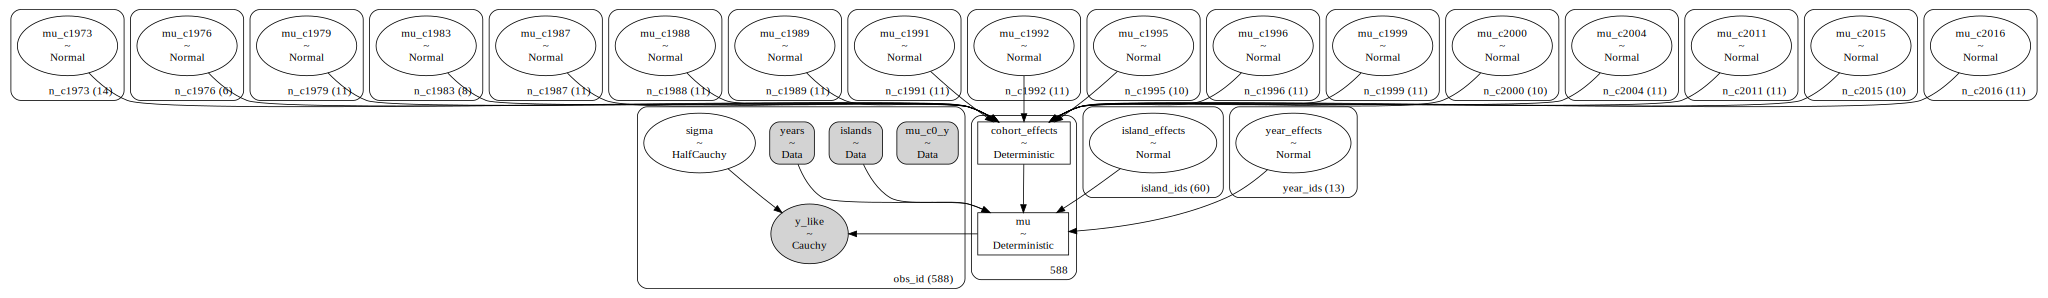

In [ ]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])

# 次元の定義
coords = {
    'island_ids': unique_island_ids,
    'year_ids': unique_years,
    'n_c1973': c1973,
    'n_c1976': c1976,
    'n_c1979': c1979,
    'n_c1983': c1983,
    'n_c1987': c1987,
    'n_c1988': c1988,
    'n_c1989': c1989,
    'n_c1991': c1991,
    'n_c1992': c1992,
    'n_c1995': c1995,
    'n_c1996': c1996,
    'n_c1999': c1999,
    'n_c2000': c2000,
    'n_c2004': c2004,
    'n_c2011': c2011,
    'n_c2015': c2015,
    'n_c2016': c2016,
    'obs_id': df.index
}

with pm.Model(coords=coords) as staggered:
    # data
    islands = pm.Data('islands', df['island_ids'], dims='obs_id')
    years = pm.Data('years', df['years'], dims='obs_id')
    mu_c0_y = pm.Data('mu_c0_y', df['years_cohort_0'], dims='obs_id')

    # priors
    island_effects = pm.Normal('island_effects', mu=0, sigma=100, dims='island_ids')
    year_effects = pm.Normal('year_effects', mu=0, sigma=100, dims='year_ids')

    # model error
    sigma = pm.HalfCauchy('sigma', beta=1000000, dims='obs_id')

    # cohort * passage
    mu_c1973 = pm.Normal('mu_c1973', mu=0, sigma=100, dims='n_c1973')
    mu_c1976 = pm.Normal('mu_c1976', mu=0, sigma=100, dims='n_c1976')
    mu_c1979 = pm.Normal('mu_c1979', mu=0, sigma=100, dims='n_c1979')
    mu_c1983 = pm.Normal('mu_c1983', mu=0, sigma=100, dims='n_c1983')
    mu_c1987 = pm.Normal('mu_c1987', mu=0, sigma=100, dims='n_c1987')
    mu_c1988 = pm.Normal('mu_c1988', mu=0, sigma=100, dims='n_c1988')
    mu_c1989 = pm.Normal('mu_c1989', mu=0, sigma=100, dims='n_c1989')
    mu_c1991 = pm.Normal('mu_c1991', mu=0, sigma=100, dims='n_c1991')
    mu_c1992 = pm.Normal('mu_c1992', mu=0, sigma=100, dims='n_c1992')
    mu_c1995 = pm.Normal('mu_c1995', mu=0, sigma=100, dims='n_c1995')
    mu_c1996 = pm.Normal('mu_c1996', mu=0, sigma=100, dims='n_c1996')
    mu_c1999 = pm.Normal('mu_c1999', mu=0, sigma=100, dims='n_c1999')
    mu_c2000 = pm.Normal('mu_c2000', mu=0, sigma=100, dims='n_c2000')
    mu_c2004 = pm.Normal('mu_c2004', mu=0, sigma=100, dims='n_c2004')
    mu_c2011 = pm.Normal('mu_c2011', mu=0, sigma=100, dims='n_c2011')
    mu_c2015 = pm.Normal('mu_c2015', mu=0, sigma=100, dims='n_c2015')
    mu_c2016 = pm.Normal('mu_c2016', mu=0, sigma=100, dims='n_c2016')

    cohort_effects = pm.math.dot(c1973, mu_c1973) + pm.math.dot(c1976, mu_c1976) + pm.math.dot(c1979, mu_c1979) + pm.math.dot(c1983, mu_c1983) + pm.math.dot(c1987, mu_c1987) + pm.math.dot(c1988, mu_c1988) + pm.math.dot(c1989, mu_c1989) + pm.math.dot(c1991, mu_c1991) + pm.math.dot(c1992, mu_c1992) + pm.math.dot(c1995, mu_c1995) + pm.math.dot(c1996, mu_c1996) + pm.math.dot(c1999, mu_c1999) + pm.math.dot(c2000, mu_c2000) + pm.math.dot(c2004, mu_c2004) + pm.math.dot(c2011, mu_c2011) + pm.math.dot(c2015, mu_c2015) + pm.math.dot(c2016, mu_c2016)

    # expectation
    mu = pm.Deterministic('mu', island_effects[islands] + year_effects[years] + cohort_effects)

    # likelihood
    y_like = pm.Cauchy('y_like', alpha=mu, beta=sigma, observed=df['population_change_rate'].values, dims='obs_id')

pm.model_to_graphviz(staggered)

In [22]:
with staggered:
    idata_staggered = pm.sample(draws=3000, tune=2000, nuts_sampler="numpyro", random_seed=123, target_accept=.95)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [24]:
az.to_netcdf(idata_staggered, './sample/sample_baysian_did_staggered.nc')

'./sample/sample_baysian_did_staggered.nc'

In [94]:
az.summary(idata_staggered, hdi_prob=0.95, var_names=['cohort_effects'])

mean       sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
cohort_effects[0]   -10.144  116.468  -254.962    216.426     26.594   19.098   
cohort_effects[1]   -38.107   92.613  -181.922    184.922     21.630   15.545   
cohort_effects[2]     4.273   89.960  -217.429    172.902      9.376   11.394   
cohort_effects[3]   -11.400   95.254  -206.248    208.402     20.868   14.968   
cohort_effects[4]   -32.178  114.228  -187.783    242.544     34.509   25.082   
...                     ...      ...       ...        ...        ...      ...   
cohort_effects[583]  20.979   30.067   -32.008     63.490     13.100   10.468   
cohort_effects[584]  20.979   30.067   -32.008     63.490     13.100   10.468   
cohort_effects[585]  20.979   30.067   -32.008     63.490     13.100   10.468   
cohort_effects[586]  20.979   30.067   -32.008     63.490     13.100   10.468   
cohort_effects[587]  20.979   30.067   -32.008     63.490     13.100   10.468   

                     ess_bulk  ess_tail  r_hat  
cohort_effects[0]        19.0     121.0   1.16  
cohort_effects[1]        20.0      49.0   1.24  
cohort_effects[2]        65.0     145.0   1.18  
cohort_effects[3]        18.0      38.0   1.18  
cohort_effects[4]        11.0     134.0   1.30  
...                       ...       ...    ...  
cohort_effects[583]       5.0      13.0   2.02  
cohort_effects[584]       5.0      13.0   2.02  
cohort_effects[585]       5.0      13.0   2.02  
cohort_effects[586]       5.0      13.0   2.02  
cohort_effects[587]       5.0      13.0   2.02  

[588 rows x 9 columns]

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


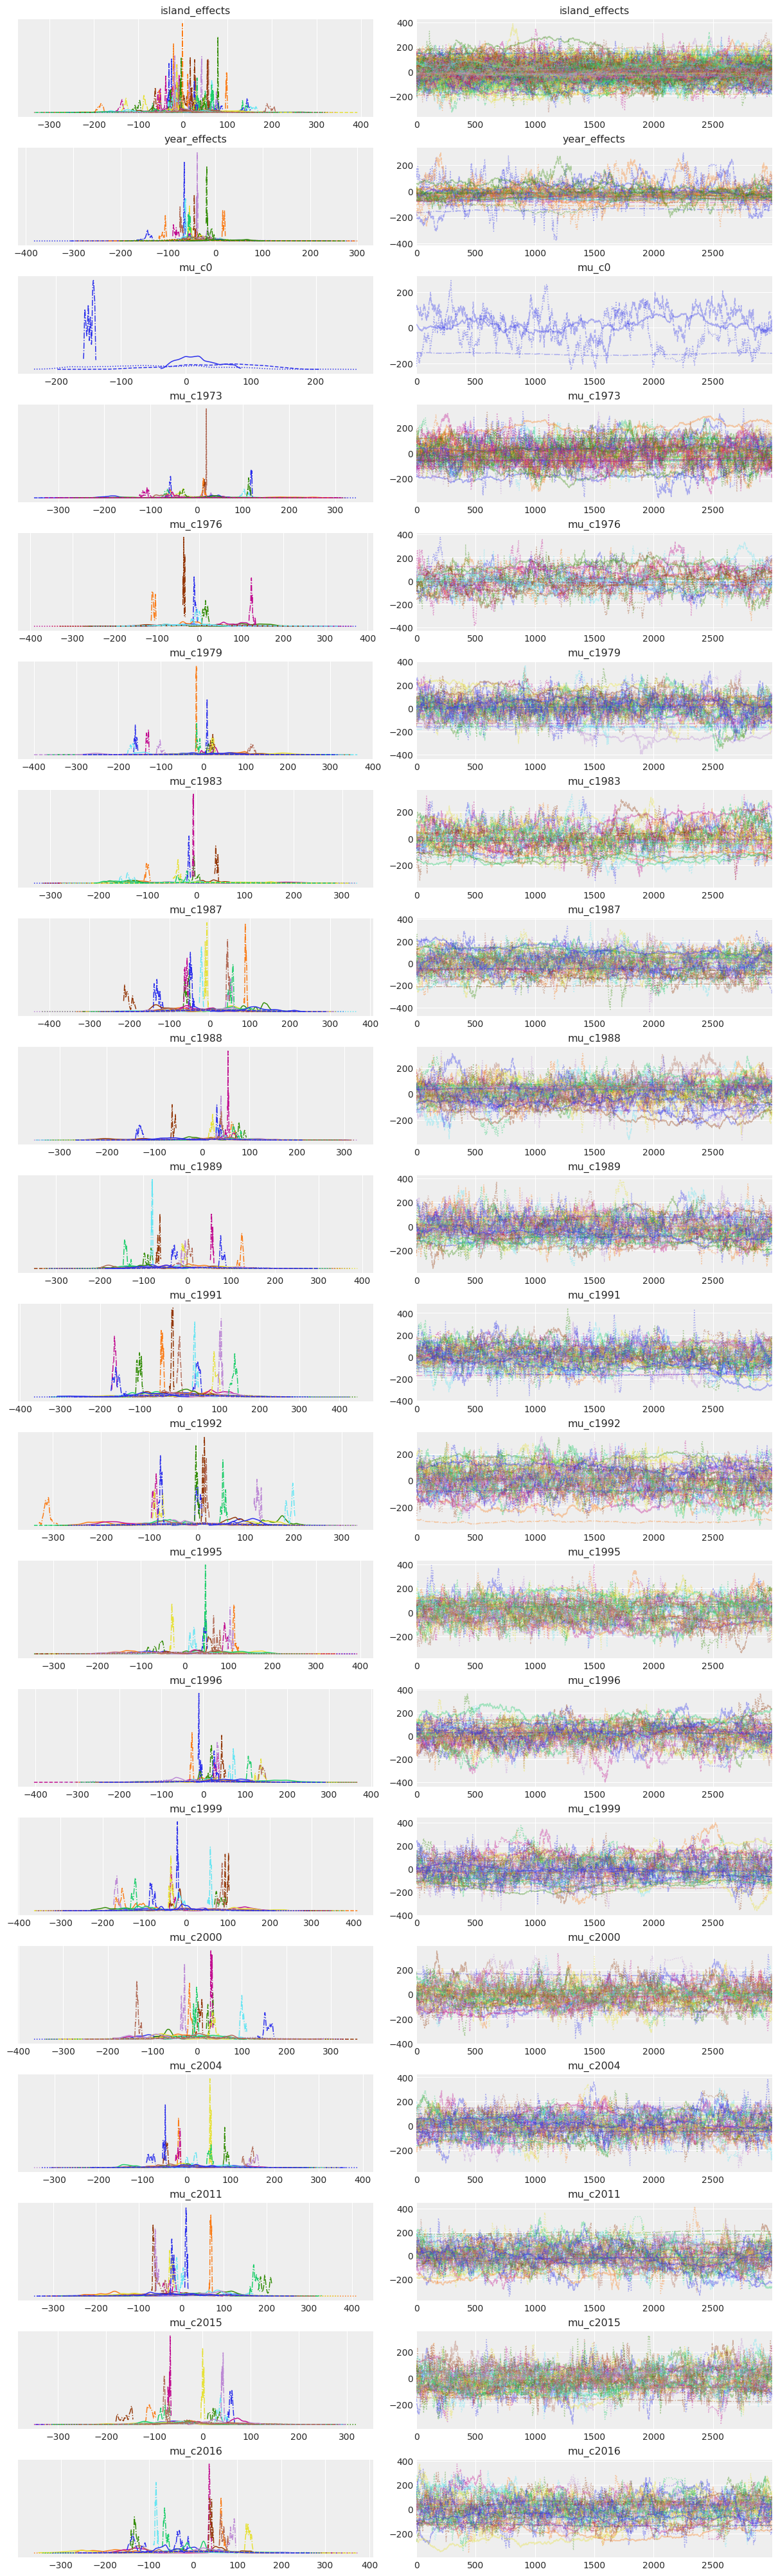

In [26]:
az.plot_trace(idata_staggered);

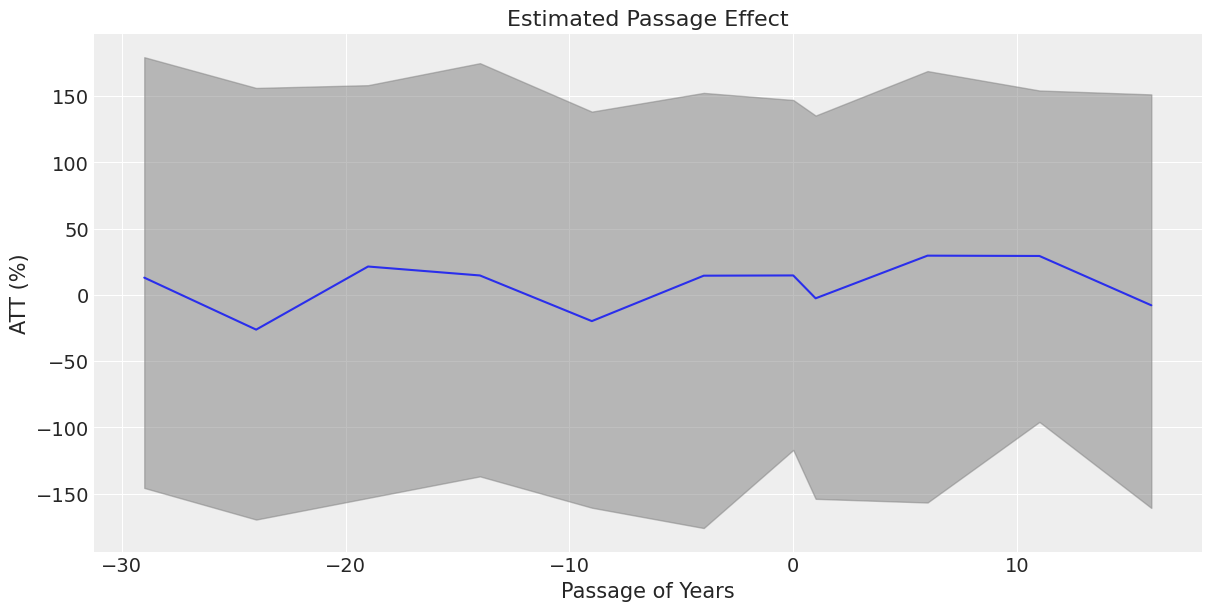

In [93]:
summary = az.summary(idata_staggered, var_names=['mu_c2004'], hdi_prob=.95)
df_cohort_effects = summary.reset_index()
# 数値部分を取り出す関数
def extract_number(index_str):
    match = re.search(r'\[(-?\d+)\]', index_str)
    return int(match.group(1)) if match else None

# 数値部分を新しい列として追加
df_cohort_effects['passage_years'] = df_cohort_effects['index'].apply(extract_number)
df_cohort_effects.sort_values('passage_years', inplace=True)

plt.figure(figsize=(12, 6))
sns.lineplot(x='passage_years', y='mean', data=df_cohort_effects)
plt.fill_between(
    df_cohort_effects['passage_years'],
    df_cohort_effects['hdi_2.5%'],
    df_cohort_effects['hdi_97.5%'],
    color='gray', alpha=0.5, label='95% HDI'
)
plt.title('Estimated Passage Effect')
plt.xlabel('Passage of Years')
plt.ylabel('ATT (%)')
plt.show()

In [77]:
df_cohort_effects

index    mean       sd  hdi_2.5%  hdi_97.5%  \
0   mu_c1979[C(years_cohort_1979)[-4]] -46.801   92.209  -164.541    127.768   
1    mu_c1979[C(years_cohort_1979)[0]]  20.933   55.050   -77.651    120.318   
2    mu_c1979[C(years_cohort_1979)[1]]   1.936   75.909  -168.718    140.805   
3    mu_c1979[C(years_cohort_1979)[6]] -18.797   89.587  -137.181    160.695   
4   mu_c1979[C(years_cohort_1979)[11]]  53.052   76.834   -87.632    214.552   
5   mu_c1979[C(years_cohort_1979)[16]] -69.693  103.924  -182.453    132.682   
6   mu_c1979[C(years_cohort_1979)[21]]  47.335   98.531  -116.837    238.904   
7   mu_c1979[C(years_cohort_1979)[26]]  -0.336   78.524  -162.858    192.152   
8   mu_c1979[C(years_cohort_1979)[31]] -87.340  112.367  -289.133    126.687   
9   mu_c1979[C(years_cohort_1979)[36]]  48.131   78.776  -147.457    138.794   
10  mu_c1979[C(years_cohort_1979)[41]]  23.267   70.769  -150.513    178.178   

    mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  passage_years  
0      35.375   26.174       7.0      34.0   1.52             -4  
1      19.182   14.076      10.0      45.0   1.40              0  
2      13.248   10.986      32.0      54.0   1.48              1  
3      34.360   25.422       8.0      35.0   1.49              6  
4      22.821   16.661      13.0      60.0   1.56             11  
5      40.898   30.337       6.0     128.0   1.67             16  
6      35.294   26.845       8.0      23.0   1.67             21  
7      10.532   12.825      49.0      71.0   1.58             26  
8      43.576   32.275       7.0      44.0   1.63             31  
9      24.744   18.026      10.0     137.0   1.34             36  
10      6.806    8.387      46.0     149.0   1.51             41

In [6]:
idata = az.from_netcdf('./bm_twfe_sampling.nc')